In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import glob
from math import sqrt
SPINE_COLOR = 'gray'

In [2]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'pdf',
              'text.latex.preamble': ['\\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8,       #'text.fontsize': 8, # was 10
              'legend.fontsize': 6.5, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'lines.linewidth' : 0.4,
              'lines.markersize' : 0.4,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

linewidth=497
DPI=96
#latexify(fig_width=linewidth/DPI, fig_height=int(linewidth/2.3/DPI))
latexify(fig_width=linewidth/DPI/1.7, fig_height=int(linewidth/2.3/DPI))

In [ ]:
#PING: single experiment
#SCATTERPLOT - PING + rtt values over time
'''
for f in glob.iglob('./*1016-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'ack_delay', 'srtt', 'rtt_var', 'state'])
                                                        # KPIs FROM BEFORE 18.10.2019!
                                                        
    #dping = pd.read_csv('./20191015-1314_1hr_ping/20191015-1314_client_ping_grep', delim_whitespace=True, 
                        names = ['seconds_offset', 'ping_number', 'ping_rtt'])
    
    df.current_rtt = df.current_rtt.apply(lambda x: x / 1000) #from us to ms
    df.srtt = df.srtt.apply(lambda x: x / 1000)
    title=f
    print(f)
    
    print(df.current_rtt.mean(),
          df.srtt.mean(),
          dping.ping_rtt.mean())
    
    
    fig = dping.plot(x="ping_number", y="ping_rtt", kind='scatter', color="DarkBlue", s=0.01)
    x = df.seconds_offset
    y1 = df.current_rtt
    fig.plot(x,y1,'r:') # more examples = 'b:' 'k:' 'r--'
    y2 = df.srtt
    fig.plot(x,y2, 'y:')

    axes = plt.gca()
    fig.legend(['Current RTT', 'Smoothed RTT', 'Ping RTT'])
    fig.set_xlabel('Runtime (seconds)')
    lines = fig.set_ylabel('Time (ms)')
    plt.tight_layout()
    plt.savefig(f+"_timing+ping.pdf")
    
    axes.set_ylim([0,250])
    #axes.set_xlim([-5,605])
    plt.savefig(f+"_timing+ping_limit.pdf")
'''

       dfe100  dfe200  dfe500
5       2.444   2.537   2.526
7       2.444   2.617   2.289
9       2.685   2.594   2.518
11      2.415   2.371   2.746
13      2.493   2.714   2.451
15      2.684   2.744   2.456
17      2.537   2.548   2.724
19      2.434   2.950   2.783
21      2.297   2.726   2.789
23      2.424   2.462   2.804
25      2.503   2.656   2.669
27      2.935   2.876   2.465
29      2.629   2.781   2.560
31      2.363   2.485   2.561
33      2.509   2.499   2.500
35      2.817   2.656   2.717
37      2.824   2.606   2.771
39      2.778   2.538   2.747
41      2.540   2.567   2.784
43      2.702   2.838   2.931
45      2.388   2.613   2.636
47      2.653   2.663   2.626
49      2.615   2.713   2.657
51      2.530   2.480   2.644
53      2.657   2.865   2.542
55      2.437   2.517   2.762
57      2.503   2.632   2.857
59      2.509   2.647   2.610
61      2.641   2.409   2.787
63      2.780   2.546   2.747
65      2.791   2.705   2.647
67      2.728   2.627   2.505
69      2.

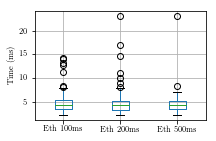

In [19]:
#WiFi vs ETH
#BOXPLOT - application RTT (current rtt)
dfe100 = pd.read_csv('./analysis_wifi-vs-eth/eth_100ms_36k-msgs/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
dfe200 = pd.read_csv('./analysis_wifi-vs-eth/eth_200ms_36k-msgs/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfe500 = pd.read_csv('./analysis_wifi-vs-eth/eth_500ms_36k-msgs/firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])

dfe100 = dfe100[dfe100.index % 2 != 0]
dfe100 = dfe100[dfe100.state == 15]
dfe200 = dfe200[dfe200.index % 2 != 0]
dfe200 = dfe200[dfe200.state == 15]
dfe500 = dfe500[dfe500.index % 2 != 0]
dfe500 = dfe500[dfe500.state == 15]

df = pd.DataFrame()
df['dfe100'] = dfe100.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfe200'] = dfe200.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfe500'] = dfe500.current_rtt.apply(lambda x: x / 1000) #from us to ms


print(df.to_string())

fig = df.boxplot(showfliers=True) #showfliers=False -> circles outside of the boxplot

plt.xticks([1, 2, 3], ['Eth 100ms', 'Eth 200ms', 'Eth 500ms'])
fig.set_ylabel('Time (ms)')
plt.tight_layout()
plt.savefig("./analysis_wifi-vs-eth/rtt_boxplots_eth_100-200-500ms.pdf")


In [ ]:
#WiFi vs ETH
#BOXPLOT - application RTT (current rtt)

dfw200 = pd.read_csv('./eth-vs-wifi/20191025-1451_200ms-5min_wifi_firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfw200_long = pd.read_csv('./eth-vs-wifi/20191023-1635_200ms-2hr_wifi_firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
dfe200 = pd.read_csv('./eth-vs-wifi/20191029-1406_200ms-5min_eth_firstKPIs', delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 

df = pd.DataFrame()
df['dfw200_long'] = dfw200_long.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfw200'] = dfw200.current_rtt.apply(lambda x: x / 1000) #from us to ms
df['dfe200'] = dfe200.current_rtt.apply(lambda x: x / 1000) #from us to ms

print(df.to_string())

fig = df.boxplot()

plt.xticks([1, 2, 3], ['WiFi 200ms', 'WiFi 200ms', 'Eth 200ms'])
fig.set_ylabel('Time (ms)')
plt.tight_layout()
plt.savefig("./eth-vs-wifi/rtt_boxplots_200ms.pdf")


In [ ]:
#SCATTERPLOT - rtt values over time
for f in glob.iglob('./*1023-*200ms*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
        
    df.current_rtt = df.current_rtt.apply(lambda x: x / 1000) #from us to ms
    df.srtt = df.srtt.apply(lambda x: x / 1000)
    df.rtt_min = df.rtt_min.apply(lambda x: x / 1000)
    title=f
    print(f)
    
    print(df.current_rtt.mean(),
          df.srtt.mean())
    
    fig = df.plot(x="seconds_offset", y="rtt_min", kind='scatter', color="DarkBlue", s=0.01)
    x = df.seconds_offset
    y2 = df.srtt
    fig.plot(x,y2, 'y.')
    y1 = df.current_rtt
    fig.plot(x,y1, 'r.') # more examples = 'b:' 'k:' 'r--'

    axes = plt.gca()
    fig.legend(['Current RTT', 'Smoothed RTT', 'min RTT'])
    fig.set_xlabel('Runtime (seconds)')
    lines = fig.set_ylabel('Time (ms)')
    plt.tight_layout()
    plt.savefig(f+"_timing.pdf")
    
    axes.set_ylim([0,25])
    #axes.set_xlim([-5,1000])
    plt.savefig(f+"_timing_limit.pdf")

In [ ]:
#BOXPLOTS - rtt values (Current RTT + Smoothed RTT)
# 1 plot for x files
for f in glob.iglob('./*1018-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    df.current_rtt = df.current_rtt.apply(lambda x: x / 1000) #from us to ms
    df.srtt = df.srtt.apply(lambda x: x / 1000)
    title=f
    print(f)
    
    #delete unnecessary data
    df.drop(['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 'rtt_min', 
             'send_time', 'reception_time', 'current_ackdelay', 'rtt_var','max_ackdelay', 'state'], axis=1, inplace=True)
    
    #delete initial values
    df.drop(df.index[0], inplace=True)
    
    fig = plt.figure() #this line makes a plot for every file
    fig = df.boxplot()
    plt.xticks([1, 2], ['Current RTT', 'Smoothed RTT'])
    fig.set_ylabel('Time (ms)')
    plt.tight_layout()
    plt.savefig(f+"_timing_boxplots.pdf")

In [ ]:
#SCATTERPLOT - congestion window
for f in glob.iglob('./*1018-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    title=f
    print(f)
    
    fig = df.plot(x="seconds_offset", y="cwin", marker=",", markersize="0.01", color="DarkBlue", linestyle="None")

    axes = plt.gca()
    #axes.set_ylim([0,20])
    #axes.set_xlim([-5,605])
    axes.get_legend().remove()
    
    fig.set_xlabel('Runtime (seconds)')
    lines = fig.set_ylabel('Congestion Window')
    plt.tight_layout()
    plt.savefig(f+"_cwin.pdf")
    
    fig.set_yscale('log')
    plt.savefig(f+"_cwin_ylog.pdf")

In [ ]:
#SCATTERPLOT retransmissions over time
for f in glob.iglob('./*1018-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    title=f
    print(f)
    
    df.drop_duplicates(subset="nb_ret", keep="first", inplace=True)
    df.drop(df.index[0], inplace=True)
    df.state = df.state.apply(lambda x: x - 14)
    
    num_retrans = 'Retransmissions = '+ str(df.state.count())
    print(num_retrans, "\n")
    
    fig = df.plot(x="seconds_offset", y="state", marker="x", markersize="0.1", color="DarkBlue", linestyle="None")
    
    fig.text(df['seconds_offset'].max()*0.75, 0.95, num_retrans, horizontalalignment='center', verticalalignment='center')
    fig.set_xlabel('Runtime (seconds)')
    lines = fig.set_ylabel('Retransmission=1')
    plt.tight_layout()
    plt.savefig(f+"_retransOverTime.pdf")


In [ ]:
# CUMULATIVE DISTRIBUTION FUNCTION - time between retransmissions
# 1 plot for x files
for f in glob.iglob('./*1018-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    title=f
    
    #delete the normal (no-retransmission) packets
    df.drop_duplicates(subset="nb_ret", keep="first", inplace=True)
    df.drop(df.index[0], inplace=True)
    df.state = df.state.apply(lambda x: x - 14)
    
    num_retrans = 'Retransmissions = '+ str(df.seconds_offset.count())
    print(num_retrans, "\n")
    
    #compute the time between retransmissions
    i = 0;
    timeBetween = [];
    for j in df['seconds_offset']:
        timeBetween.append(j-i)
        i = j
        
    df['timeBetween'] = timeBetween
    sortedRetrans = df['timeBetween'].sort_values()
    #print(sortedRetrans)
    #print(df.seconds_offset)
    
    #build the CDF
    cum_dist = np.linspace(0.,1.,len(sortedRetrans))
    cdf = pd.Series(cum_dist, index=sortedRetrans)
    fig = plt.figure() #this line makes a plot for every file
    fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
    fig.text(sortedRetrans.max()*0.75, 0, num_retrans, horizontalalignment='center', verticalalignment='center')

    fig.set_xlabel('Time between retransmissions (s)')
    plt.tight_layout()
    plt.savefig(f+"_cdf_retransTimeBetween.pdf")


In [ ]:
# COMPLEMENTARY CUMULATIVE DISTRIBUTION FUNCTION - time between retransmissions
# 1 plot for x files
for f in glob.iglob('./*1018-*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    title=f
    
    #delete the normal (no-retransmission) packets
    df.drop_duplicates(subset="nb_ret", keep="first", inplace=True)
    df.drop(df.index[0], inplace=True)
    df.state = df.state.apply(lambda x: x - 14)
    
    num_retrans = 'Retransmissions = '+ str(df.seconds_offset.count())
    print(num_retrans, "\n")
    
    #compute the time between retransmissions
    i = 0;
    timeBetween = [];
    for j in df['seconds_offset']:
        timeBetween.append(j-i)
        i = j
        
    df['timeBetween'] = timeBetween
    sortedRetrans = df['timeBetween'].sort_values()
    #print(sortedRetrans)
    #print(df.seconds_offset)
    
    #build the CDF
    cum_dist = np.linspace(1.,0.,len(sortedRetrans))
    cdf = pd.Series(cum_dist, index=sortedRetrans)
    fig = plt.figure() #this line makes a plot for every file
    fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
    fig.text(sortedRetrans.max()*0.75, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')

    fig.set_xlabel('Time between retransmissions (s)')
    plt.tight_layout()
    plt.savefig(f+"_ccdf_retransTimeBetween.pdf")
    
    fig.set_yscale('log')
    plt.savefig(f+"_ccdf_retransTimeBetween_ylog.pdf")
    
    axes = plt.gca() 
    axes.set_xlim([0,100])
    fig.text(60, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')
    plt.savefig(f+"_ccdf_retransTimeBetween_yloglim.pdf")

In [ ]:
#SCATTERPLOT - rtt values over time
#COMPARISON to TIMING VALUES
for f in glob.iglob('./*1023-*200*/*firstKPIs', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                                        'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                                        'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state']) 
                                                        #extraction of KPI: update from 18.10.19
    #calculate the comparison value
    df['recept_send'] = df.reception_time - df.send_time
    df['deviation'] = df.recept_send - df.current_rtt
    df = df[df.state == 15] #only values after successful start are comparable (earlier, there is no send or reception time set)
    
    df.current_rtt = df.current_rtt.apply(lambda x: x / 1000) #from us to ms
    df.srtt = df.srtt.apply(lambda x: x / 1000)
    df.rtt_min = df.rtt_min.apply(lambda x: x / 1000)
    df.recept_send = df.recept_send.apply(lambda x: x / 1000)
    df.deviation = df.deviation.apply(lambda x: x / 1000)
    df.current_ackdelay = df.current_ackdelay.apply(lambda x: x / 1000)
    df.max_ackdelay = df.max_ackdelay.apply(lambda x: x / 1000)
    
    title=f
    print(f)
    
    print('Current RTT mean: ' + str(df.current_rtt.mean()) + '\n',
          'SRTT mean: ' + str(df.srtt.mean()) + '\n',
         'Calculated reception-send mean: ' + str(df.recept_send.mean()) + '\n',
         'Deviation mean: ' + str(df.deviation.mean()) + '\n')
    
    standard = 0; #1 = standard plot over time
                  #0 = deviation plotted over time
    
    if(standard):
        fig = df.plot(x="seconds_offset", y="rtt_min", kind='scatter', color="DarkBlue", s=0.01)
        x = df.seconds_offset
        y1 = df.current_rtt
        fig.plot(x,y1,'r:') # more examples = 'b:' 'k:' 'r--'
        y2 = df.recept_send
        fig.plot(x,y2, 'y:')

        axes = plt.gca()
        fig.legend(['Current RTT', 'recept minus send', 'min RTT'])
        fig.set_xlabel('Runtime (seconds)')
        lines = fig.set_ylabel('Time (ms)')
        plt.tight_layout()
        plt.savefig(f+"_timing-comparison.pdf")
    
    #Plotting only deviation values
    else:
        df['deviation'] = df['deviation'].replace(0.0, np.nan) #set all 0.0 to NaN -> not plotted
        df.dropna(inplace=True)
        print(df[['seconds_offset', 'current_rtt', 'recept_send', 
                  'deviation', 'current_ackdelay', 'max_ackdelay']].to_string(index=False))

        fig = df.plot(x="seconds_offset", y="deviation", kind='scatter', color="DarkBlue", s=0.01)
        x = df.seconds_offset
        
        num_deviations = 'Differences = ' + str(df.deviation.count())
        print(num_deviations, "\n")
        #fig.text(df.seconds_offset.max()*0.9, df.deviation.max()*0.9, num_deviations, horizontalalignment='center', verticalalignment='center')

        axes = plt.gca()
        fig.legend(['Deviation'])
        fig.set_xlabel('Runtime (seconds)  [' + num_deviations + ']')
        lines = fig.set_ylabel('Time (ms)')
        plt.tight_layout()
        plt.savefig(f+"_timing-deviation_cleaned.pdf")

In [ ]:
#SINGLE EXPERIMENT
# Compute the time from pcap files
# Comparison with current_rtt from application

for f in glob.iglob('./*1029-08*/*client_filter_pcap', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    df = pd.read_csv(f, delim_whitespace=True, float_precision='round_trip', names = ['seconds_offset', 'framenumber', 'datasize']) 
                                                        #extraction of PCAP: update from 28.10.19
    title=f
    print(f)
    
    dfserver = pd.read_csv('./20191029-0810_500ms-5min_pcap2_eth/server_filter_pcap', delim_whitespace=True, float_precision='round_trip', 
                                                                          names = ['seconds_offset', 'framenumber', 'datasize'])
    
    #TODO: Cut firstKPIs short to cover only the same packets as in filtered PCAP
    dfcomp = pd.read_csv('./20191029-0810_500ms-5min_pcap2_eth/firstKPIs', delim_whitespace=True, 
                        names = ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb_ret', 
                                 'rtt_min', 'current_rtt', 'send_time','reception_time', 
                                 'current_ackdelay', 'srtt', 'rtt_var', 'max_ackdelay', 'state'])
    
    #set the indices
    i=0
    j=1
    k=2
    
    rtt1 = []
    rtt2 = []
    frameNumber = []
    frameNumber1 = []
    frameNumber2 = []
    dataSize1 = []
    dataSize2 = []
    
    
    client2server = []
    server2client = []
    serverprocessingtime = []
    
    num_packets = df.seconds_offset.count()/3

    #compute the pcap rtt's: first reply - request = rtt1, 
    #                        second reply - request = rtt2,
    #                        server_receive - client_sent
    for x in range(num_packets.astype(int)):
        frameNumber.append(df.at[i, 'framenumber'])
        rtt1.append(df.at[j, 'seconds_offset'] - df.at[i, 'seconds_offset'])
        frameNumber1.append(df.at[j, 'framenumber'])
        dataSize1.append(df.at[j, 'datasize'])
        rtt2.append(df.at[k, 'seconds_offset'] - df.at[i, 'seconds_offset'])
        frameNumber2.append(df.at[k, 'framenumber'])
        dataSize2.append(df.at[k, 'datasize'])
        
        client2server.append(dfserver.at[i, 'seconds_offset'] - df.at[i, 'seconds_offset'])
        serverprocessingtime.append(dfserver.at[j, 'seconds_offset'] - dfserver.at[i, 'seconds_offset'])
        server2client.append(df.at[j, 'seconds_offset'] - dfserver.at[j, 'seconds_offset'])
        
        i=i+3
        j=j+3
        k=k+3
        
    
    df2 = pd.DataFrame()
    df2['frame'] = frameNumber
    df2['app_rtt'] = dfcomp['current_rtt']
    df2['clientrtt1'] = rtt1
    #df2['frame+1'] = frameNumber1
    #df2['size1'] = dataSize1
    #df2['client_rtt2'] = rtt2
    #df2['frame+2'] = frameNumber2
    #df2['size2'] = dataSize2
    
    df2['client2server'] = client2server
    df2['server2client'] = server2client
    df2['serverprocessingtime'] = serverprocessingtime
    
    df2.app_rtt = df2.app_rtt.apply(lambda x: x / 1000) #from us to ms
    df2.clientrtt1 = df2.clientrtt1.apply(lambda x: x * 1000) #from s to ms
    #df2.client_rtt2 = df2.client_rtt2.apply(lambda x: x * 1000)
    df2.client2server = df2.client2server.apply(lambda x: x * 1000)
    df2.server2client = df2.server2client.apply(lambda x: x * 1000)
    df2.serverprocessingtime = df2.serverprocessingtime.apply(lambda x: x * 1000)
    
    print(df2.to_string())
    
    fig = df2.plot(x="frame", y="clientrtt1", kind='line', color="DarkBlue", linestyle=':')
    
    
    fig.set_xlabel('packet number')
    fig.set_ylabel('measured time (ms)')
    plt.tight_layout()
    plt.savefig(f+"_analysis.pdf")

In [ ]:
#iperf UDP

dfserver = pd.read_csv('./iperf_tests/20191028-1019_udp/server_filter_pcap', delim_whitespace=True, float_precision='round_trip', 
                                                                          names = ['seconds_offset', 'framenumber', 'datasize'])
dfclient = pd.read_csv('./iperf_tests/20191028-1019_udp/client_filter_pcap', delim_whitespace=True, float_precision='round_trip', 
                                                                          names = ['seconds_offset', 'framenumber', 'datasize'])

client2server = []
clienttime = []
client_firstoffset = dfclient.at[0, 'seconds_offset']
servertime = []

for x in range(dfclient.seconds_offset.count()):
    client2server.append(dfserver.at[x, 'seconds_offset'] - dfclient.at[x, 'seconds_offset'])
    #clienttime.append(dfclient.at[x, 'seconds_offset'] - client_firstoffset)
    #servertime.append(dfserver.at[x, 'seconds_offset'] - client_firstoffset)
    

df = pd.DataFrame()
#df['client_time'] = clienttime
#df['server_time'] = servertime
df['client2server'] = client2server

df.client2server = df.client2server.apply(lambda x: x * 1000) #from s to ms


print(df.to_string())


#fig = df.plot()

#fig.set_xlabel('index')
#fig.set_ylabel('measured time (ms)')
#plt.tight_layout()
#plt.savefig("./iperf_tests/20191028-1019_udp/client_filter_pcap_analysis.pdf")

In [ ]:
#iperf TCP

dfserver = pd.read_csv('./iperf_tests/20191029-1136_tcp/server_filter_pcap_acks', delim_whitespace=True, float_precision='round_trip', 
                                                                          names = ['seconds_offset', 'framenumber', 'rtt'])
dfclient = pd.read_csv('./iperf_tests/20191029-1136_tcp/client_filter_pcap_acks', delim_whitespace=True, float_precision='round_trip', 
                                                                          names = ['seconds_offset', 'framenumber', 'rtt'])

dfclient = dfclient.apply(lambda x: x * 1000) #from s to ms
dfserver = dfserver.apply(lambda x: x * 1000)


fig = dfclient.plot(y='rtt', use_index=True)
#x = dfserver.index
#y1 = dfserver.rtt
#fig.plot(x,y1,'r:')

fig.set_xlabel('index')
fig.set_ylabel('measured time (ms)')
plt.tight_layout()
plt.savefig("./iperf_tests/20191029-1136_tcp/client_filter_pcap_analysis.pdf")